# Projet 4 - P4 – Anticipez les besoins en consommation électrique de bâtiments
Contexte: Nous travaillons pour la ville de Seattle, qui s'est fixée pour objectif d'être une ville neutre en émisssions carbone d'ici 2050. A cette fin nous avons pour mission d'élaborer un modèle qui permette de prédire la consommation énergétique et les rejets en CO2 de bâtiments à partir des données de leur permis d'exploitation, c'est à dire avant même qu'ils ne soient construits.

Le jeu de données est disponible à l'adresse suivante: 
https://www.kaggle.com/city-of-seattle/sea-building-energy-benchmarking#2015-building-energy-benchmarking.csv

Le but de ce projet est d'essayer différents modèles de régression afin de prédire le plus efficacement possible les besoins énergétiques des bâtiments de la ville de Seattle.
Dans ce notebook, 4 modèles de régression seront testés successivement:
- k-NN
- Régression Lasso
- Random Forest
- Réseau de neurones

In [1]:
# Importer les librairies
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import time
import sklearn
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler, MaxAbsScaler, MinMaxScaler, StandardScaler

# Version des modules
print('Pandas:', pd.__version__)
print('Matplotlib:', matplotlib.__version__)
print('Numpy:', np.__version__)
print('Seaborn:', sns.__version__)
print('Scikit-learn:', sklearn.__version__)

Pandas: 1.0.5
Matplotlib: 3.2.2
Numpy: 1.19.5
Seaborn: 0.11.1
Scikit-learn: 0.23.1


In [2]:
# Option afficher toutes les colonnes
pd.set_option('display.max_columns', None)

# Import du jeu de données
data2015 = pd.read_csv('2015-building-energy-benchmarking.csv')
data2016 = pd.read_csv('2016-building-energy-benchmarking.csv')

## Sélection des variables

Le but de cette première partie est d'arriver à cibler les variables pertinentes pour notre modèle. Même si l'on se doute pour certaines variables qu'elles n'auront aucune influence sur notre prédiction, il y a des features pour lesquelles cela est plus ambigu. 

Nous allons dans un premier temps procéder à un premier tri en ne gardant que les features suffisamment renseignées et en retirant celles dont la non-pertinence nous apparait évidente (numéro d'identification, état, code postal, etc...).

In [3]:
sns.set()

In [4]:
# Fonction qui renvoit le nom du dataframe utilisé
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

In [5]:
# Fonction qui graphe le pourcentage de valeurs manquantes par colonne
def tracer_nan_rate(df, seuil=1):
    # Nom dataframe
    name = get_df_name(df)
    # Pourcentage de valeurs manquantes
    nan_rate = df.isnull().mean().sort_values()*100

    # Bar plot valeurs manquantes > 1%
    nan_rate[nan_rate>seuil].plot.barh(title=f'Valeurs manquantes de {name} par colonne (%)')

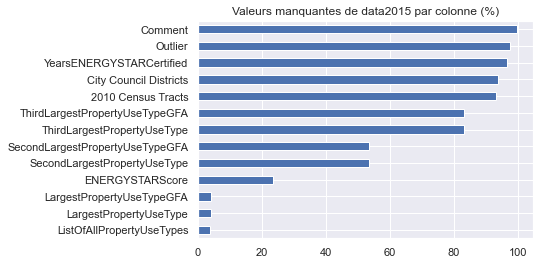

In [6]:
tracer_nan_rate(data2015)

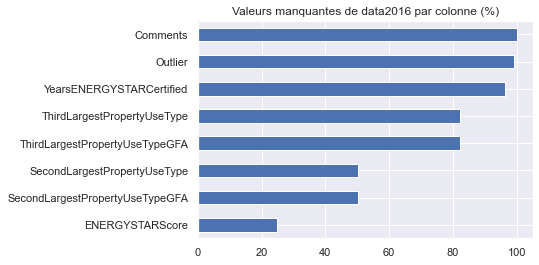

In [7]:
tracer_nan_rate(data2016)

On choisit d'éliminer les variables présentant un taux de valeurs manquantes supérieur à 30%.

In [8]:
def get_index_nan(df, seuil):
    # Pourcentage de valeurs manquantes
    nan_rate = df.isnull().mean()*100
    # On choisit un taux de valeurs manquantes maximum (%) égal à seuil
    return nan_rate[nan_rate<seuil].index

In [9]:
index15 = get_index_nan(data2015, 30)
index15

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'TaxParcelIdentificationNumber', 'Location',
       'CouncilDistrictCode', 'Neighborhood', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)',
       'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)',
       'OtherFuelUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)',
       'GHGEmissionsIntensity(kgCO2e/ft2)', 'DefaultData', 'ComplianceStatus',
       'Seattle Police Department Micro Community Policing Plan Areas',
       'SPD Beats', 'Zip Codes'],
      dtype='object')

In [10]:
index16 = get_index_nan(data2016, 30)
index16

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'Address', 'City', 'State', 'ZipCode',
       'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)',
       'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)',
       'DefaultData', 'ComplianceStatus', 'TotalGHGEmissions',
       'GHGEmissionsIntensity'],
      dtype='object')

In [11]:
# Supression des features trop incomplètes
data2015 = data2015[index15]
data2016 = data2016[index16]

### Harmonisation des features
En vue d'utiliser les données des deux années il faut utiliser les mêmes features entre les deux datasets. 

In [12]:
column_2015 = set(data2015.columns)
column_2016 = set(data2016.columns)
common_columns = column_2015.intersection(column_2016)
unique_2015 = column_2015.difference(common_columns)
unique_2016 = column_2016.difference(common_columns)

In [13]:
# common_columns

In [14]:
unique_2015

{'GHGEmissions(MetricTonsCO2e)',
 'GHGEmissionsIntensity(kgCO2e/ft2)',
 'Location',
 'OtherFuelUse(kBtu)',
 'SPD Beats',
 'Seattle Police Department Micro Community Policing Plan Areas',
 'Zip Codes'}

In [15]:
unique_2016

{'Address',
 'City',
 'GHGEmissionsIntensity',
 'Latitude',
 'Longitude',
 'State',
 'TotalGHGEmissions',
 'ZipCode'}

In [16]:
data2015['Location'].head()

0    {'latitude': '47.61219025', 'longitude': '-122...
1    {'latitude': '47.61310583', 'longitude': '-122...
2    {'latitude': '47.61334897', 'longitude': '-122...
3    {'latitude': '47.61421585', 'longitude': '-122...
4    {'latitude': '47.6137544', 'longitude': '-122....
Name: Location, dtype: object

Après inspection des colonnes différentes entre les deux dataframes:
- La colonne *Location* du dataframe de 2015 a besoin d'être découpée en *Latitude* et *Longitude* afin de correspondondre au dataframe de 2016;
- La colonne *GHGEmissions(MetricTonsCO2e)* doit être renommée en *TotalGHGEmissions*.

Les autres colonnes ne nous paraissent pas pertinentes et seront supprimées.

In [17]:
import ast

In [18]:
# Décomposition de la colonne 'Location'
lat=[]
long = []
for row in data2015['Location']:
    a=ast.literal_eval(row)
    lat.append(float(a['latitude']))
    long.append(float(a['longitude']))

data2015['Latitude']=lat
data2015['Longitude']=long

In [19]:
# Colonne à renommer
data2015['TotalGHGEmissions'] = data2015['GHGEmissions(MetricTonsCO2e)']

In [20]:
# Colonnes à supprimer
column_2015 = set(data2015.columns)
column_2016 = set(data2016.columns)
common_columns = column_2015.intersection(column_2016)
unique_2015 = column_2015.difference(common_columns)
unique_2016 = column_2016.difference(common_columns)

In [21]:
# Suppression
data2015.drop(columns=unique_2015, inplace=True)
data2016.drop(columns=unique_2016, inplace=True)

In [22]:
# Les colonnes sont identiques
data2015.columns.difference(data2016.columns)

Index([], dtype='object')

In [23]:
# On les réindexe dans le même ordre
data2015 = data2015.reindex(data2016.columns, axis=1)

In [24]:
# Conversion "Yes, No" en "0, 1"
data2015['DefaultData'] = data2015['DefaultData'].map({'Yes':1,'No':0})

In [25]:
# Conversion "True, False" en "0, 1"
data2016['DefaultData'] = data2016['DefaultData'].astype(np.int64)

In [26]:
# Liste des variables
data2015.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'TaxParcelIdentificationNumber', 'CouncilDistrictCode',
       'Neighborhood', 'Latitude', 'Longitude', 'YearBuilt',
       'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
       'NaturalGas(kBtu)', 'DefaultData', 'ComplianceStatus',
       'TotalGHGEmissions'],
      dtype='object')

## Nettoyage
Avant de fusionner les deux dataframes il convient de les nettoyer individuellement afin de détecter plus facilement les erreurs aberrantes.

In [27]:
# residential = ['Multifamily LR (1-4)',
#     'Multifamily MR (5-9)',
#     'Multifamily HR (10+)']

In [28]:
positive_feat = ['NumberofFloors',
                 'PropertyGFATotal', 
                 'PropertyGFAParking', 
                 'ENERGYSTARScore',]

In [29]:
def clean_df(df):
    # Vérification doublons
    doublons = df.groupby(by='OSEBuildingID').size().sum() - len(df)
    print(f'Le dataframe contient {doublons} doublons.')
    
#     # Suppression des bâtiments résidentiels
#     l = len(df)
#     df = df[~df['BuildingType'].isin(residential)]
#     print(f'{l - len(df)} bâtiments résidentiels ont été supprimés.')
    
    # Suppression des lignes inutiles
    l = len(df)
    df = df[(df['SiteEnergyUse(kBtu)'] > 0) & (df['TotalGHGEmissions'] > 0)]
    print(f'{l - len(df)} lignes avec cible nulle ont été supprimées.')
    
    # Suppression des erreurs aberrantes
    energies = ['SteamUse(kBtu)',
           'Electricity(kBtu)',
           'NaturalGas(kBtu)']
    df['somme_energies'] = df[energies].sum(axis=1)
    
    l = len(df)
    df = df[df['SiteEnergyUse(kBtu)'] > 0.98*df['somme_energies']]  # On tolère un écart de 2% pour tenir compte des erreurs d'arrondis
    print(f'{l - len(df)} erreurs ont été supprimées.')
    
    df.drop(columns='somme_energies', inplace = True)
    
    # Features strictement positives
    l = len(df)
    for feat in positive_feat:
        df = df[(df[feat]>=0) | (df[feat].isnull())]  # On élimine les valeurs négatives mais on garde si valeur manquante
    print(f'{l - len(df)} valeurs négatives supprimées.')
       
    return df

In [30]:
data2015 = clean_df(data2015)

Le dataframe contient 0 doublons.
12 lignes avec cible nulle ont été supprimées.
3 erreurs ont été supprimées.
2 valeurs négatives supprimées.


<ipython-input-29-e50c304d1af6>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['somme_energies'] = df[energies].sum(axis=1)


In [31]:
data2016 = clean_df(data2016)

Le dataframe contient 0 doublons.
30 lignes avec cible nulle ont été supprimées.
5 erreurs ont été supprimées.
0 valeurs négatives supprimées.


<ipython-input-29-e50c304d1af6>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['somme_energies'] = df[energies].sum(axis=1)


## Sélection des variables pertinentes

Critères de sélection des variables:

**Données permettant la jointure des deux dataframes (on les supprimera ensuite):**
- **OSEBuildingID**: ID du bâtiment
- **DataYear**: année des relevés de consommation

**Données relatives à la problématique métier:**
- **BuildingType** : type du bâtiment (hôtel, caserne de pompier...)
- **PrimaryPropertyType** : activité principale du bâtiment
- **Neighborhood**: quartier
- **Latitude** et **Longitude**: on peut imaginer que l'emplacement géographique ait un impact sur la consommation pour plusieurs facteurs (différence de température, d'exposition aux éléments, ancienneté des installations, etc...). Peut-être redondant avec la variable *Neighborhood*
- **YearBuilt**: année de construction
- **NumberofBuildings**: nombre de bâtiments
- **NumberofFloors**: nombre d'étages
- **PropertyGFATotal**: surface totale
- **PropertyGFAParking**: surface allouée au parking (consommation quasi nulle)
- **PropertyGFABuilding(s)**: surface allouée au bâtiment (information a priori redondante)
- **ListOfAllPropertyUseTypes**: liste de toutes les activités du bâtiment
- **LargestPropertyUseType**: activité dont la surface est la plus élevée
- **LargestPropertyUseTypeGFA**: surface allouée à cette activité
- **ENERGYSTARScore**: indice censé représenter la bonne utilisation des ressources énergétiques

**Eviter fuite de données (suppression des relevés de consommation)**


In [32]:
# Premier tri "à la main"
features = ['OSEBuildingID', 
            'DataYear', 
            'BuildingType', 
            'PrimaryPropertyType',
#             'PropertyName', 
#             'TaxParcelIdentificationNumber', 
#             'CouncilDistrictCode',
            'Neighborhood', 
            'Latitude', 
            'Longitude', 
            'YearBuilt',
            'NumberofBuildings', 
            'NumberofFloors', 
            'PropertyGFATotal',
            'PropertyGFAParking', 
            'PropertyGFABuilding(s)',
            'ListOfAllPropertyUseTypes', 
            'LargestPropertyUseType',
            'LargestPropertyUseTypeGFA', 
            'ENERGYSTARScore', 
#             'SiteEUI(kBtu/sf)',
#             'SiteEUIWN(kBtu/sf)', 
#             'SourceEUI(kBtu/sf)', 
#             'SourceEUIWN(kBtu/sf)',
            'SiteEnergyUse(kBtu)', 
#             'SiteEnergyUseWN(kBtu)', 
#             'SteamUse(kBtu)',
#             'Electricity(kWh)', 
#             'Electricity(kBtu)', 
#             'NaturalGas(therms)',
#             'NaturalGas(kBtu)', 
#             'DefaultData', 
            'ComplianceStatus',
            'TotalGHGEmissions']

In [33]:
targets = ['SiteEnergyUse(kBtu)', 'TotalGHGEmissions']

In [34]:
# Supression des variables non pertinentes
data2015=data2015[features]
data2016=data2016[features]

### Valeurs manquantes

In [35]:
# Fonction permettant d'afficher quelle feature possède des valeurs manquantes
def afficher_val_nan(df):
    liste_nan = df.isnull().sum()
    return liste_nan[liste_nan>0]

In [36]:
# Valeurs manquantes par feature
afficher_val_nan(data2015)

NumberofFloors                 8
ListOfAllPropertyUseTypes    124
LargestPropertyUseType       133
LargestPropertyUseTypeGFA    133
ENERGYSTARScore              767
dtype: int64

In [37]:
# Valeurs manquantes par feature
afficher_val_nan(data2016)

LargestPropertyUseType        11
LargestPropertyUseTypeGFA     11
ENERGYSTARScore              817
dtype: int64

On enregistre dans une nouvelle colonne le nombre de valeurs manquantes par ligne pour les deux dataframes. Lors de la jointure on privilégiera la ligne qui possède le moins de valeurs manquantes.

In [38]:
data2015['n_nan'] = data2015.isnull().sum(axis=1)
data2016['n_nan'] = data2016.isnull().sum(axis=1)

### Concaténation des dataframes

In [39]:
data_all = pd.concat([data2015, data2016], ignore_index=True)

In [40]:
# Tri sur nombres de valeurs manquantes
data_all.sort_values(by='n_nan', inplace=True)

In [41]:
# Combien de batiments sont répertoriés à la fois en 2015 et en 2016?
size = data_all.groupby('OSEBuildingID').size()
len(size[size==2])

3241

In [42]:
# On ne garde que la ligne avec le moins de valeurs manquantes
data_all = data_all.groupby('OSEBuildingID').first().reset_index()

In [43]:
# Echantillon total
len(data_all)

3423

In [44]:
# Supression des colonnes qui ne servent qu'à la jointure
data_all.drop(columns=['OSEBuildingID','DataYear','n_nan'], inplace=True)

In [45]:
# Valeurs manquantes par feature
afficher_val_nan(data_all)

ListOfAllPropertyUseTypes     21
LargestPropertyUseType        27
LargestPropertyUseTypeGFA     27
ENERGYSTARScore              771
dtype: int64

In [46]:
# Taux de valeurs manquantes de l'ENERGY Star Score
afficher_val_nan(data_all)['ENERGYSTARScore']/len(data_all)

0.2252410166520596

Le taux de valeurs manquantes de l'*ENERGY Star Score* est trop élevé pour être approximé par la moyenne du dataset sans influencer négativement les résultats.

- Cette variable sera supprimée lorsque nous prédirons la consommation énergétique;
- Les lignes avec valeurs manquantes sur l'*ENERGY Star Score* seront supprimées lorsque nous prédirons les émissions de CO2;
- Les autres variables numériques sont approximées par la moyenne;
- Les variables catégorielles sont approximées par le mode.

In [47]:
# Index des features numériques
num_idx = data_all.dtypes[(data_all.dtypes != 'object') & (data_all.dtypes != 'bool')].index

In [48]:
# On remplace les valeurs manquantes des variables  
# numériques par la moyenne de la colonne
for feat in num_idx:
    if feat != 'ENERGYSTARScore':
        data_all[feat].fillna(data_all[feat].mean(), inplace=True)

In [49]:
# Index des features catégorielles
cat_idx = data_all.dtypes[(data_all.dtypes == 'object') ].index

In [50]:
# On remplace les valeurs manquantes des variables  
# catégorielles par le mode
for feat in cat_idx:
    data_all[feat].fillna(data_all[feat].value_counts().idxmax(), inplace=True)

In [51]:
# Valeurs manquantes par feature
afficher_val_nan(data_all)

ENERGYSTARScore    771
dtype: int64

In [52]:
data_orig = data_all.copy()

In [53]:
data_all = data_orig.copy()

In [54]:
data_all.shape

(3423, 18)

## Analyse exploratoire

In [55]:
def tracer_boxplot(df):
    """
    Fonction permettant de représenter le boxplot des colonnes d'un dataframe
    """
    df = df.select_dtypes(include=np.number)
    df = df.drop(columns=targets)

    n_feat = df.shape[1]
    if n_feat % 4 == 0:
        n_row = int(n_feat/4)
    else:
        n_row = int(n_feat/4) + 1
    
    fig = plt.figure(figsize=(16, n_row*5))
    for feat_idx in range(n_feat):
        data = df.iloc[:, feat_idx]
        ax = fig.add_subplot(n_row, 4, (feat_idx+1))
        h = ax.boxplot(data[~np.isnan(data)])

        ax.set_title(df.columns[feat_idx], fontsize=14)

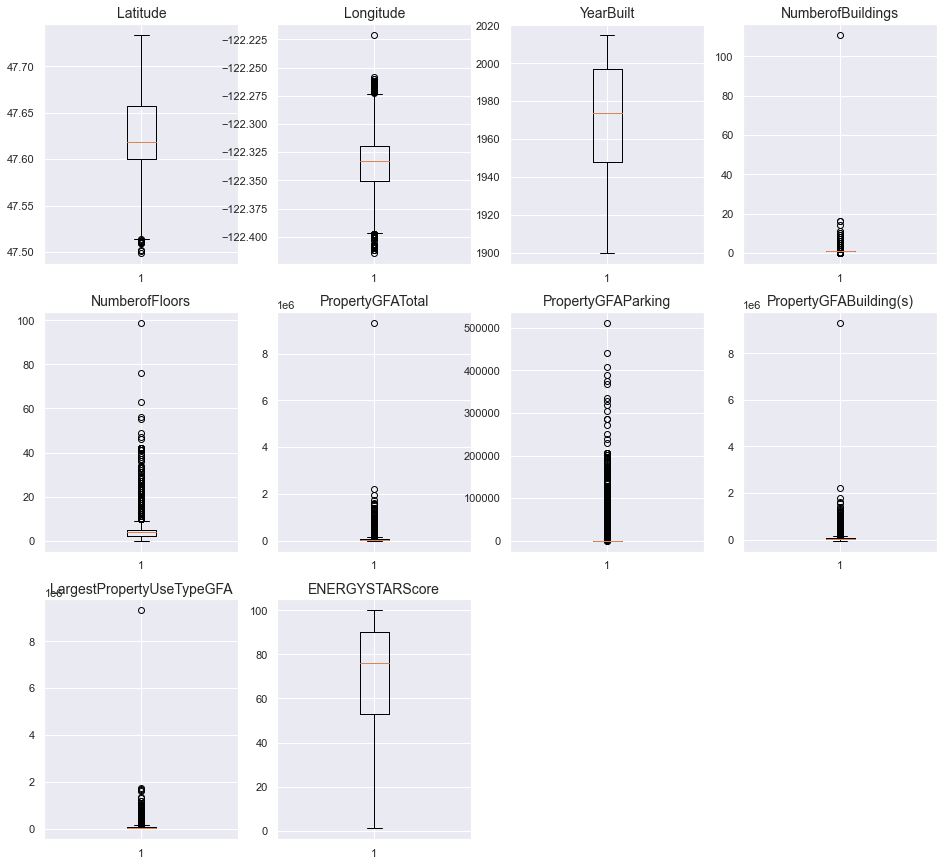

In [56]:
tracer_boxplot(data_all)

In [57]:
# Suppression manuelle des outliers
l = len(data_all)
data_all = data_all[data_all['PropertyGFATotal']<450000]
data_all = data_all[data_all['PropertyGFAParking']<200000]
data_all = data_all[data_all['NumberofFloors']<40]
data_all = data_all[data_all['NumberofBuildings']<14]
data_all = data_all[data_all['LargestPropertyUseTypeGFA']<400000]
print(f'{l - len(data_all)} outliers ont été supprimées.')

104 outliers ont été supprimées.


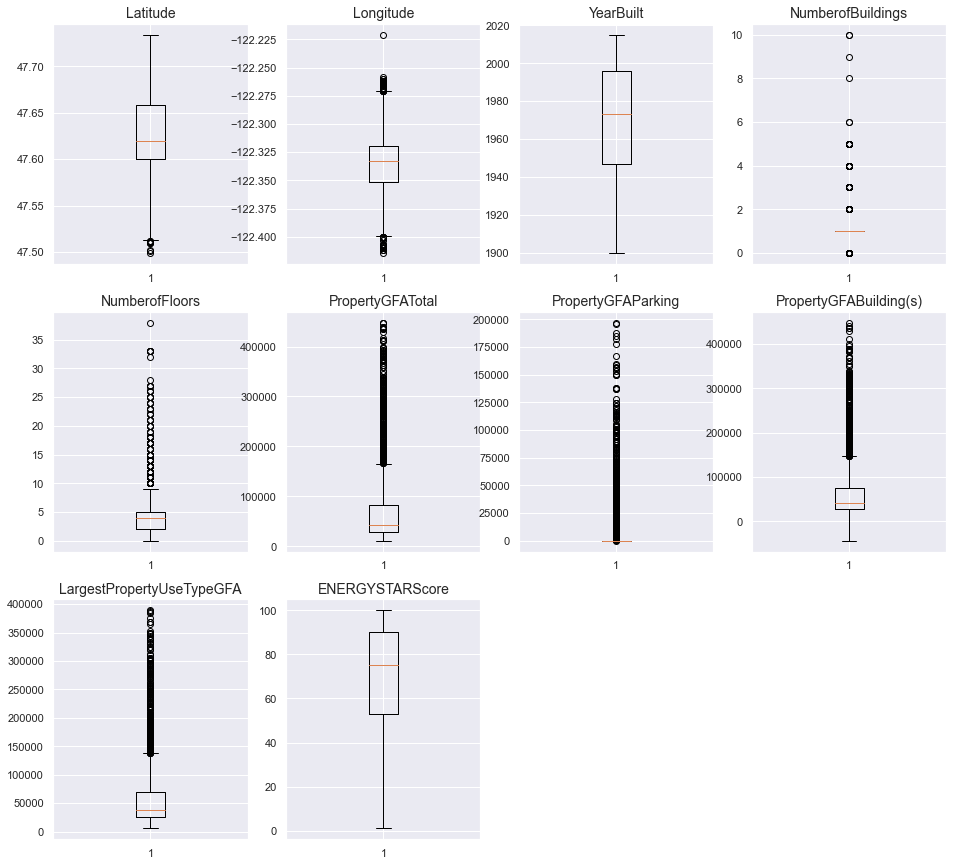

In [58]:
tracer_boxplot(data_all)

Nous avons supprimé à la main les valeurs atypiques sur nos variables explicatives. Cependant dans un contexte professionel il faudra également anticiper la possibilité qu'on puisse nous présenter un bâtiment qui présente des valeurs atypiques selon les critères définis ci-dessus. Dans ce cas on pourrait imaginer fournir une notice qui permette d'avoir une estimation plus fiable que celle de notre modèle qui ne sera sans doute plus adapté. Cette partie ne sera pas traitée dans ce notebook.

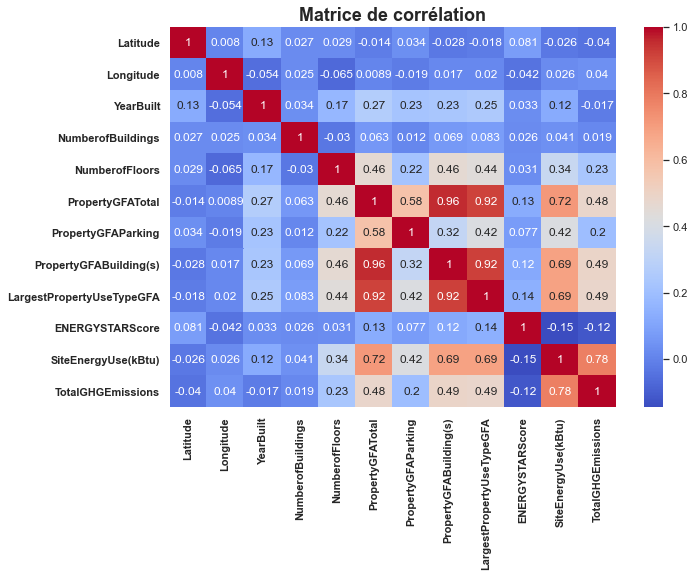

In [62]:
# Matrice de corrélation
df_corr = data_all.corr()
f,ax=plt.subplots(figsize=(10,7))
sns.heatmap(df_corr, 
            annot=True,
            cmap = 'coolwarm')
plt.title("Matrice de corrélation", 
          weight='bold', 
          fontsize=18)
plt.xticks(weight='bold')
plt.yticks(weight='bold')

plt.show()

- La matrice de corrélation montre une forte corrélation entre les variables explicatives *PropertyGFATotal*, *PropertyGFABuilding(s)* et *LargestPropertyUseTypeGFA*. On choisit de ne garder que la première des trois.

In [63]:
data_all.drop(columns=['PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA'], inplace=True)

## Feature engineering
Nous allons appliquer les transformations suivantes à notre jeu de données:
- On créera les variables corespondant aux proportions de chaque énergie utilisée;
- Nous allons appliquer log(x +1) aux features qui présentent une forte asymétrie à droite (asymétrie positive) pour les rapprocher d'une distribution normale;
- On créera les dummy variables pour les features catégorielles;
- Nous utiliserons un scaler pour avoir des ordres de grandeur similaires entre les variables lorsque cela est nécessaire (l'algorithme kNN dans notre cas);

### Transformations des distributions
Traçons la distribution de nos variables numériques de départ.

In [64]:
def tracer_distrib(df):
    """
    Fonction permettant de représenter la distribution des colonnes d'un dataframe
    """
    numeric_index = df.dtypes[(df.dtypes != 'object') & (df.dtypes != 'bool')].index
    df = df[numeric_index]
    n_feat = df.shape[1]
    if n_feat % 4 == 0:
        n_row = int(n_feat/4)
    else:
        n_row = int(n_feat/4) + 1
    
    fig = plt.figure(figsize=(16, n_row*5))
    for feat_idx in range(n_feat):
        ax = fig.add_subplot(n_row, 4, (feat_idx+1))
        h = ax.hist(df.iloc[:, feat_idx], bins=50, color='steelblue', density=True, edgecolor='none')
        ax.set_title(df.columns[feat_idx], fontsize=14)

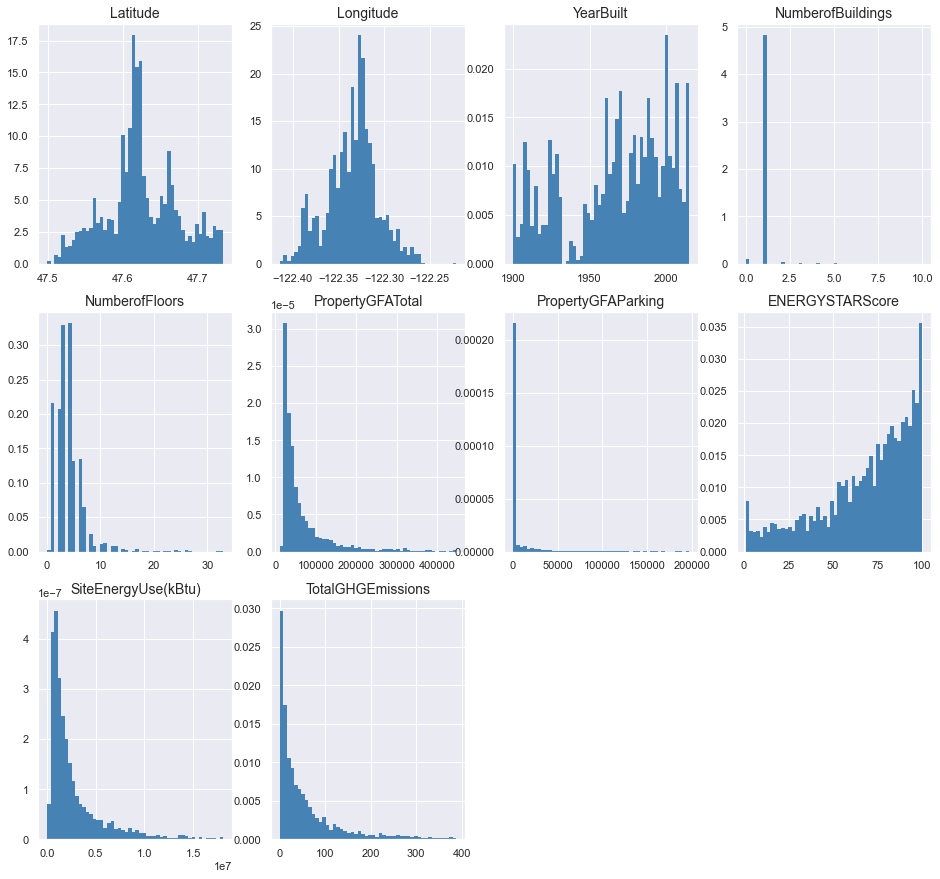

In [65]:
tracer_distrib(data_all)

In [66]:
afficher_val_nan(data_all)

ENERGYSTARScore    692
dtype: int64

In [67]:
targets = ['SiteEnergyUse(kBtu)', 'TotalGHGEmissions']

In [68]:
from scipy.stats import skew

# Index des features numériques
num_idx = data_all.dtypes[(data_all.dtypes != 'object') & (data_all.dtypes != 'bool')].index

# Variables présentant une forte asymétrie positive
skewed_feats = data_all[num_idx].apply(lambda x: skew(x.dropna())) # calcul asymétrie
skewed_feats = skewed_feats[skewed_feats > 0.75].index

# Transformation log(1+x)
for feat in skewed_feats:
    if feat not in targets:
        data_all[feat] = np.log1p(data_all[feat])

In [69]:
skewed_feats

Index(['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'SiteEnergyUse(kBtu)', 'TotalGHGEmissions'],
      dtype='object')

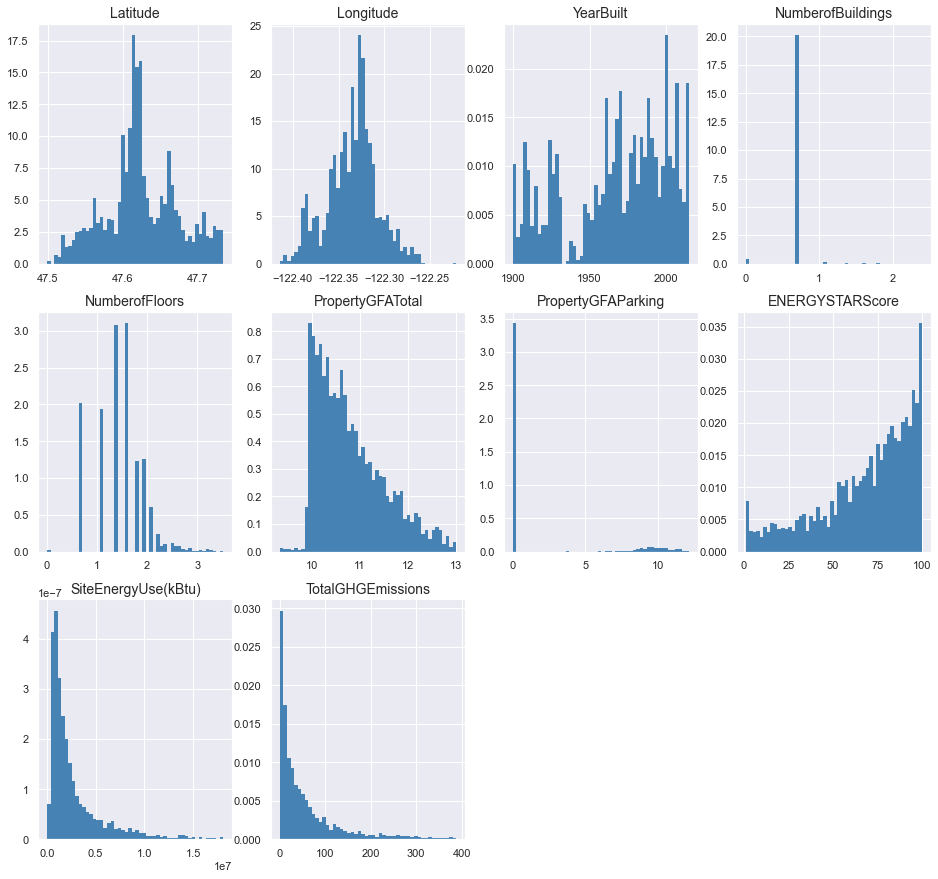

In [70]:
tracer_distrib(data_all)

Nos variables quantitatives sont mieux distribuées.

### Encodage des variables catégorielles

Pour pouvoir être utilisées dans nos algorithmes de machine learning, les variables catégorielles doivent être encodées en 0 et 1.

In [71]:
# Nombre de catégories par feature
data_all[cat_idx].nunique()

BuildingType                   8
PrimaryPropertyType           31
Neighborhood                  19
ListOfAllPropertyUseTypes    405
LargestPropertyUseType        54
ComplianceStatus               3
dtype: int64

Garder la variable catégorielle **ListOfAllPropertyUseTypes** signifierait la décomposer en 373 dummy variables, ce qui est assez conséquent. Nous garderons dans un premier temps simplement la variable **LargestPropertyUseType** qui ne donne que le type de l'activité majoritaire du batiment.

In [72]:
# Types de bâtiments représentés
data_all.groupby(by='LargestPropertyUseType').size().sort_values(ascending=False)

LargestPropertyUseType
Multifamily Housing                                     1679
Office                                                   437
Non-Refrigerated Warehouse                               197
K-12 School                                              138
Retail Store                                              95
Other                                                     86
Worship Facility                                          70
Hotel                                                     56
Distribution Center                                       52
Senior Care Community                                     38
Supermarket/Grocery Store                                 37
Medical Office                                            32
Self-Storage Facility                                     28
Other - Recreation                                        27
Residence Hall/Dormitory                                  22
Parking                                                   19
O

Cette feature nous paraît intéressante. En effet on peut penser que connaître avec une plus grande précision le type de service d'un batiment nous renseigne beaucoup sur sa consommation, qui est forcément en lien avec ses activités.

In [73]:
cat_to_keep =['Neighborhood', 
              'ComplianceStatus', 
              'PrimaryPropertyType',
              'BuildingType', 
#               'ListOfAllPropertyUseTypes', 
              'LargestPropertyUseType']

In [74]:
data_dummies = pd.get_dummies(data_all[cat_to_keep])

In [75]:
data_dummies.head()

,Neighborhood_BALLARD,Neighborhood_Ballard,Neighborhood_CENTRAL,Neighborhood_Central,Neighborhood_DELRIDGE,Neighborhood_DELRIDGE NEIGHBORHOODS,Neighborhood_DOWNTOWN,Neighborhood_Delridge,Neighborhood_EAST,Neighborhood_GREATER DUWAMISH,Neighborhood_LAKE UNION,Neighborhood_MAGNOLIA / QUEEN ANNE,Neighborhood_NORTH,Neighborhood_NORTHEAST,Neighborhood_NORTHWEST,Neighborhood_North,Neighborhood_Northwest,Neighborhood_SOUTHEAST,Neighborhood_SOUTHWEST,ComplianceStatus_Compliant,ComplianceStatus_Error - Correct Default Data,ComplianceStatus_Non-Compliant,PrimaryPropertyType_College/University,PrimaryPropertyType_Distribution Center,PrimaryPropertyType_Distribution Center\n,PrimaryPropertyType_High-Rise Multifamily,PrimaryPropertyType_Hospital,PrimaryPropertyType_Hotel,PrimaryPropertyType_K-12 School,PrimaryPropertyType_Laboratory,PrimaryPropertyType_Large Office,PrimaryPropertyType_Low-Rise Multifamily,PrimaryPropertyType_Medical Office,PrimaryPropertyType_Mid-Rise Multifamily,PrimaryPropertyType_Mixed Use Property,PrimaryPropertyType_Non-Refrigerated Warehouse,PrimaryPropertyType_Office,PrimaryPropertyType_Other,PrimaryPropertyType_Refrigerated Warehouse,PrimaryPropertyType_Residence Hall,PrimaryPropertyType_Residence Hall/Dormitory,PrimaryPropertyType_Restaurant,PrimaryPropertyType_Restaurant\n,PrimaryPropertyType_Retail Store,PrimaryPropertyType_Self-Storage Facility,PrimaryPropertyType_Self-Storage Facility\n,PrimaryPropertyType_Senior Care Community,PrimaryPropertyType_Small- and Mid-Sized Office,PrimaryPropertyType_Supermarket / Grocery Store,PrimaryPropertyType_Supermarket/Grocery Store,PrimaryPropertyType_University,PrimaryPropertyType_Warehouse,PrimaryPropertyType_Worship Facility,BuildingType_Campus,BuildingType_Multifamily HR (10+),BuildingType_Multifamily LR (1-4),BuildingType_Multifamily MR (5-9),BuildingType_NonResidential,BuildingType_Nonresidential COS,BuildingType_Nonresidential WA,BuildingType_SPS-District K-12,LargestPropertyUseType_Adult Education,LargestPropertyUseType_Automobile Dealership,LargestPropertyUseType_Bank Branch,LargestPropertyUseType_College/University,LargestPropertyUseType_Distribution Center,LargestPropertyUseType_Financial Office,LargestPropertyUseType_Fire Station,LargestPropertyUseType_Fitness Center/Health Club/Gym,LargestPropertyUseType_Food Service,LargestPropertyUseType_Hospital (General Medical & Surgical),LargestPropertyUseType_Hotel,LargestPropertyUseType_K-12 School,LargestPropertyUseType_Laboratory,LargestPropertyUseType_Library,LargestPropertyUseType_Lifestyle Center,LargestPropertyUseType_Manufacturing/Industrial Plant,LargestPropertyUseType_Medical Office,LargestPropertyUseType_Movie Theater,LargestPropertyUseType_Multifamily Housing,LargestPropertyUseType_Museum,LargestPropertyUseType_Non-Refrigerated Warehouse,LargestPropertyUseType_Office,LargestPropertyUseType_Other,LargestPropertyUseType_Other - Education,LargestPropertyUseType_Other - Entertainment/Public Assembly,LargestPropertyUseType_Other - Lodging/Residential,LargestPropertyUseType_Other - Mall,LargestPropertyUseType_Other - Public Services,LargestPropertyUseType_Other - Recreation,LargestPropertyUseType_Other - Restaurant/Bar,LargestPropertyUseType_Other - Services,LargestPropertyUseType_Other - Utility,LargestPropertyUseType_Other/Specialty Hospital,LargestPropertyUseType_Outpatient Rehabilitation/Physical Therapy,LargestPropertyUseType_Parking,LargestPropertyUseType_Performing Arts,"LargestPropertyUseType_Personal Services (Health/Beauty, Dry Cleaning, etc)",LargestPropertyUseType_Police Station,LargestPropertyUseType_Pre-school/Daycare,LargestPropertyUseType_Prison/Incarceration,LargestPropertyUseType_Refrigerated Warehouse,"LargestPropertyUseType_Repair Services (Vehicle, Shoe, Locksmith, etc)",LargestPropertyUseType_Residence Hall/Dormitory,LargestPropertyUseType_Residential Care Facility,LargestPropertyUseType_Restaurant,LargestPropertyUseType_Retail Store,LargestPropertyUseType_Self-Storage Facility,LargestPropertyU

In [76]:
data_dummies.reset_index(drop=True, inplace=True)
data_dummies.shape

(3176, 115)

In [77]:
data_dummies

,Neighborhood_BALLARD,Neighborhood_Ballard,Neighborhood_CENTRAL,Neighborhood_Central,Neighborhood_DELRIDGE,Neighborhood_DELRIDGE NEIGHBORHOODS,Neighborhood_DOWNTOWN,Neighborhood_Delridge,Neighborhood_EAST,Neighborhood_GREATER DUWAMISH,Neighborhood_LAKE UNION,Neighborhood_MAGNOLIA / QUEEN ANNE,Neighborhood_NORTH,Neighborhood_NORTHEAST,Neighborhood_NORTHWEST,Neighborhood_North,Neighborhood_Northwest,Neighborhood_SOUTHEAST,Neighborhood_SOUTHWEST,ComplianceStatus_Compliant,ComplianceStatus_Error - Correct Default Data,ComplianceStatus_Non-Compliant,PrimaryPropertyType_College/University,PrimaryPropertyType_Distribution Center,PrimaryPropertyType_Distribution Center\n,PrimaryPropertyType_High-Rise Multifamily,PrimaryPropertyType_Hospital,PrimaryPropertyType_Hotel,PrimaryPropertyType_K-12 School,PrimaryPropertyType_Laboratory,PrimaryPropertyType_Large Office,PrimaryPropertyType_Low-Rise Multifamily,PrimaryPropertyType_Medical Office,PrimaryPropertyType_Mid-Rise Multifamily,PrimaryPropertyType_Mixed Use Property,PrimaryPropertyType_Non-Refrigerated Warehouse,PrimaryPropertyType_Office,PrimaryPropertyType_Other,PrimaryPropertyType_Refrigerated Warehouse,PrimaryPropertyType_Residence Hall,PrimaryPropertyType_Residence Hall/Dormitory,PrimaryPropertyType_Restaurant,PrimaryPropertyType_Restaurant\n,PrimaryPropertyType_Retail Store,PrimaryPropertyType_Self-Storage Facility,PrimaryPropertyType_Self-Storage Facility\n,PrimaryPropertyType_Senior Care Community,PrimaryPropertyType_Small- and Mid-Sized Office,PrimaryPropertyType_Supermarket / Grocery Store,PrimaryPropertyType_Supermarket/Grocery Store,PrimaryPropertyType_University,PrimaryPropertyType_Warehouse,PrimaryPropertyType_Worship Facility,BuildingType_Campus,BuildingType_Multifamily HR (10+),BuildingType_Multifamily LR (1-4),BuildingType_Multifamily MR (5-9),BuildingType_NonResidential,BuildingType_Nonresidential COS,BuildingType_Nonresidential WA,BuildingType_SPS-District K-12,LargestPropertyUseType_Adult Education,LargestPropertyUseType_Automobile Dealership,LargestPropertyUseType_Bank Branch,LargestPropertyUseType_College/University,LargestPropertyUseType_Distribution Center,LargestPropertyUseType_Financial Office,LargestPropertyUseType_Fire Station,LargestPropertyUseType_Fitness Center/Health Club/Gym,LargestPropertyUseType_Food Service,LargestPropertyUseType_Hospital (General Medical & Surgical),LargestPropertyUseType_Hotel,LargestPropertyUseType_K-12 School,LargestPropertyUseType_Laboratory,LargestPropertyUseType_Library,LargestPropertyUseType_Lifestyle Center,LargestPropertyUseType_Manufacturing/Industrial Plant,LargestPropertyUseType_Medical Office,LargestPropertyUseType_Movie Theater,LargestPropertyUseType_Multifamily Housing,LargestPropertyUseType_Museum,LargestPropertyUseType_Non-Refrigerated Warehouse,LargestPropertyUseType_Office,LargestPropertyUseType_Other,LargestPropertyUseType_Other - Education,LargestPropertyUseType_Other - Entertainment/Public Assembly,LargestPropertyUseType_Other - Lodging/Residential,LargestPropertyUseType_Other - Mall,LargestPropertyUseType_Other - Public Services,LargestPropertyUseType_Other - Recreation,LargestPropertyUseType_Other - Restaurant/Bar,LargestPropertyUseType_Other - Services,LargestPropertyUseType_Other - Utility,LargestPropertyUseType_Other/Specialty Hospital,LargestPropertyUseType_Outpatient Rehabilitation/Physical Therapy,LargestPropertyUseType_Parking,LargestPropertyUseType_Performing Arts,"LargestPropertyUseType_Personal Services (Health/Beauty, Dry Cleaning, etc)",LargestPropertyUseType_Police Station,LargestPropertyUseType_Pre-school/Daycare,LargestPropertyUseType_Prison/Incarceration,LargestPropertyUseType_Refrigerated Warehouse,"LargestPropertyUseType_Repair Services (Vehicle, Shoe, Locksmith, etc)",LargestPropertyUseType_Residence Hall/Dormitory,LargestPropertyUseType_Residential Care Facility,LargestPropertyUseType_Restaurant,LargestPropertyUseType_Retail Store,LargestPropertyUseType_Self-Storage Facility,LargestPropertyU

In [78]:
num_idx

Index(['Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'ENERGYSTARScore', 'SiteEnergyUse(kBtu)', 'TotalGHGEmissions'],
      dtype='object')

In [79]:
data_num = data_all[num_idx]
data_num.reset_index(drop=True, inplace=True)
data_num.shape

(3176, 10)

In [80]:
afficher_val_nan(data_num)

ENERGYSTARScore    692
dtype: int64

In [81]:
# Concaténation des deux dataframes
data_final = pd.concat([data_num, data_dummies], axis=1)

In [82]:
data_final.shape

(3176, 125)

Notre jeu de données est maintenant prêt à être exploité.

## Création des différents datasets
En fonction des cibles à prédire et des features à tester nous n'allons pas utiliser les mêmes jeux de données. Ainsi nous définissons les jeux de données suivants:

Target y0: **SiteEnergyUse(kBtu)**

- X0: jeu de données **sans** ENERGY Star Score

Target y1: **TotalGHGEmissions**
- X1: jeu de données **sans** ENERGY Star Score
- X2: jeu de données **avec** ENERGY Star Score

X0 et X1 sont différents car la variable ENERGYSTARScore possède des valeurs manquantes.
X1 et X2 ont le même nombre de lignes.

In [83]:
targets = ['SiteEnergyUse(kBtu)',
          'TotalGHGEmissions']

In [84]:
df_X0 = data_final.drop(columns = targets + ['ENERGYSTARScore'])
df_X1 = data_final.dropna().drop(columns = targets + ['ENERGYSTARScore'])
df_X2 = data_final.dropna().drop(columns = targets)

In [85]:
df_y0 = data_final['SiteEnergyUse(kBtu)']
df_y1 = data_final.dropna()['TotalGHGEmissions']
df_y2 = data_final.dropna()['TotalGHGEmissions']

### Définitions fonctions

In [86]:
# Nouvelle métrique: erreur quadratique relative
def diff_rel_mean(y_test, y_pred):
    assert len(y_test) == len(y_pred)
    return np.sqrt(np.mean(((y_pred-y_test)/y_test)**2))

In [87]:
# Nouvelle métrique: écart moyen
def diff_rel_mean(y_test, y_pred):
    assert len(y_test) == len(y_pred)
    return np.sqrt(np.mean(((y_pred-y_test)/y_test)**2))

In [88]:
# Fonction permettant d'afficher différentes métriques
def print_metrics(y_test, y_pred):
    print(f'MAE = {mean_absolute_error(y_test, y_pred):.3f}')
    print(f'MSE = {mean_squared_error(y_test, y_pred):.3f}')
    print(f'RMSE = {mean_squared_error(y_test, y_pred, squared=False):.3f}')
    print(f'R² = {r2_score(y_test, y_pred):.3f}')
    print(f'RMSLE = {np.sqrt(mean_squared_log_error(y_test, y_pred)):.3f}')
    print(f'Rel diff = {diff_rel_mean(y_test, y_pred):.3f}')

# Modélisations
- Chaque modèle est entraîné avec validation croisée à 5 folds et à l'aide d'une grille de recherche d'hyperparamètres afin de lutter contre le sur-apprentissage. 
- Comme on l'a vu plus haut, les variables cibles présentent une forte asymétrie positive. On utilise donc systématiquement un TransformTargetRegressor afin de leur appliquer la fonction log(1+x) qui permet de se rapprocher d'une distribution normale et augmenter la précision des résultats.
- Dans certains cas, une ACP est également établie afin d'augmenter la rapidité de convergence de l'algorithme et les performances de prédiction.
- Lorsqu'il y a ACP ou tout autre algorithme utilisant une distance (kNN), on normalise les données à l'aide d'un StandardScaler.
- On fixe systématiquement un random_state égal à zéro lors du split des données de façon à avoir toujours les mêmes train et test set.

## k-NN

L'algorithme k-NN repose sur la méthode des k plus proches voisins d'un point pour obtenir son appartenance à une classe, ou, en régression comme c'est le cas ici, un résultat en faisant la moyenne de ces k voisins. C'est un algorithme très simple qui ne nécessite de renseigner qu'un seul hyperparamètre: k, le nombre de voisins. Comme c'est un algorithme qui repose sur la distance il est nécessaire de standardiser les données pour avoir de meilleurs résultats.

In [132]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.neighbors import KNeighborsRegressor

In [138]:
def knn(X, y, n_pca, scaler=StandardScaler(), show_graph=False, n_max=41, step=3):
    """
    Renvoit le nombre optimal de voisins et le score R2 associé.
    Utilise une cross validation à 5 folds.
    Réduction de dimension par Analyse en Composantes Principales.
    """
    start = time.time()  
    name = get_df_name(X)
    
    # On sépare le jeu de données en training et test sets
    X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=0)

    # On cherche le nombre de voisins optimum en effectuant une validation croisée
    model_pipe = Pipeline([('scaler', scaler),
                           ('reduce_dims', PCA(n_components=n_pca)),
                           ('model', KNeighborsRegressor())])
    params = {'model__n_neighbors': list(range(1, n_max, step))}
    
    model = TransformedTargetRegressor(GridSearchCV(model_pipe, 
                                                    param_grid= params, 
                                                    cv=5,
                                                   return_train_score=True), 
                                       func=np.log1p, 
                                       inverse_func=np.expm1)

    model.fit(X_train, y_train)
    
    # Résultats
    res = model.regressor_.cv_results_
    k = res['param_model__n_neighbors']
    train_score = res['mean_train_score']
    validation_score = res['mean_test_score']
    
    # Optimum
    id_opt = validation_score.argmax()
    k_opt = k[id_opt]
#     validation_score_max = test_score[id_opt]
    temps = time.time()-start
    
    if show_graph == True:
        df_score = pd.DataFrame(dict(k=k, validation=validation_score, train=train_score))
        ax = df_score.plot(x='k', y='train', figsize=(6, 4))
        df_score.plot(x='k', y='validation', ax=ax, grid=True)
        ax.set_title("Evolution de la performance sur\nles bases d'apprentissage et de validation" +
                     "\nen fonction du nombre de voisins")
        ax.set_ylabel("r2");
        # Afficher temps de calcul
        print(f'Temps de calcul : {temps:.3f} s')
 
    # Performances sur le test set avec le modèle optimal
    model_pipe = Pipeline([('scaler', scaler),
                           ('reduce_dims', PCA(n_components=n_pca)),
                           ('model', KNeighborsRegressor(n_neighbors=k_opt))])
    model = TransformedTargetRegressor(regressor=model_pipe,
                                   func=np.log1p, 
                                   inverse_func=np.expm1)
    
    model.fit(X_train, y_train)
    test_score_max = model.score(X_test, y_test)       
    
    resultat = [y.name, name, 'k-NN', 'n_neighbors', k_opt, round(test_score_max,3), round(temps,2)]
    return resultat

Temps de calcul : 8.304 s


['SiteEnergyUse(kBtu)', 'df_X0', 'k-NN', 'n_neighbors', 10, 0.497, 8.3]

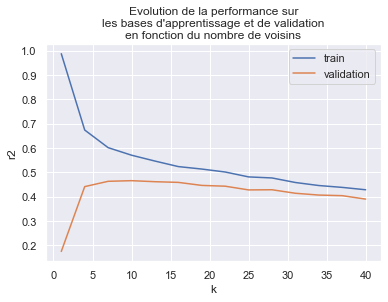

In [145]:
# avec PCA n=15
knn0 = knn(df_X0, df_y0, n_pca=15, show_graph=True)
knn0

Temps de calcul : 6.147 s


['TotalGHGEmissions', 'df_X1', 'k-NN', 'n_neighbors', 13, 0.333, 6.15]

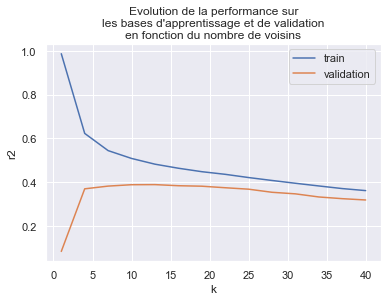

In [146]:
# avec PCA n=15
knn1 = knn(df_X1, df_y1, n_pca=15, show_graph=True)
knn1

Temps de calcul : 6.357 s


['TotalGHGEmissions', 'df_X2', 'k-NN', 'n_neighbors', 10, 0.339, 6.36]

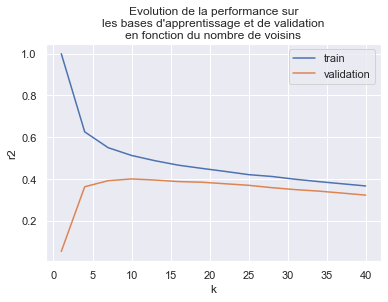

In [147]:
# avec PCA n=15
knn2 = knn(df_X2, df_y1, n_pca=15, show_graph=True)
knn2

## Random Forest 

L'algorithme Random Forest est une méthode ensembliste qui utilise des arbres décisionnels. On entraîne un certain nombre d'estimateurs sur un des échantillons au préalablement tirés avec remise (bootstrap). De ce fait chaque estimateur aura tendance à être surentraîné sur un certain type de données. Pour avoir une prédiction finale on fait simplement la moyenne de tous les estimateurs.

On lutte contre le sur-apprentissage à l'aide d'une validation croisée.

In [89]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree

In [91]:
def RF(X, y, n_pca=15, show_graph=False, n_max=51, n_step=5, depth_max=15, d_step=2):
    """
    Renvoit le nombre optimal d'estimateurs et le score R2 associé.
    Utilise une cross validation à 5 folds.
    """
    start = time.time()  
    name = get_df_name(X)
    
    # On sépare le jeu de données en training et test sets
    X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=0)
 
    # On cherche le nombre de voisins optimum en effectuant une validation croisée
    range_n = list(range(1, n_max, n_step))
    range_depth = list(range(3, depth_max, 1))
    
    model_pipe = Pipeline([
#                         ('scaler', StandardScaler()),
#                        ('reduce_dims', PCA(n_components=n_pca)),
                       ('model', RandomForestRegressor())])
    params = {'model__n_estimators': range_n,
             'model__max_depth': range_depth}
    
    model = TransformedTargetRegressor(GridSearchCV(model_pipe, 
                                                    param_grid= params, 
                                                    cv=5,
                                                   return_train_score=True), 
                                       func=np.log1p, 
                                       inverse_func=np.expm1)

    model.fit(X_train, y_train)
    
    # Résultats 
    res = model.regressor_.cv_results_
    n = res['param_model__n_estimators']
    depth = res['param_model__max_depth']
    train_score = res['mean_train_score']
    validation_score = res['mean_test_score']
    
    # Optimum
    id_opt = validation_score.argmax()
    n_opt = n[id_opt]
    depth_opt = depth[id_opt]
    validation_score_max = validation_score[id_opt]
    temps = time.time()-start
    
    # Performances sur le training set vs validation set
    if show_graph == True:
        df_validation = pd.DataFrame(dict(n=n, depth=depth, score=validation_score))
        df_validation['type'] = 'validation'
        df_train = pd.DataFrame(dict(n=n, depth=depth, score=train_score))
        df_train['type'] = 'train'
        df_score = pd.concat([df_validation, df_train], ignore_index=True)

        # Afficher temps de calcul
        print(f'Temps de calcul : {temps:.2f} s')
        
        sns.relplot(
            data=df_score, kind="line",
            x="n", 
            y="score", 
            hue="depth",
        #     palette=["darkorange", "b"],
            facet_kws=dict(sharey=False),
            col="type"
        )
    
        
    # Performances sur le test set avec le modèle optimal
    model_pipe = Pipeline([
#                         ('scaler', StandardScaler()),
#                        ('reduce_dims', PCA(n_components=n_pca)),
                       ('model', RandomForestRegressor(n_estimators=n_opt,
                                                    max_depth=depth_opt))])
    model = TransformedTargetRegressor(regressor=model_pipe,
                                   func=np.log1p, 
                                   inverse_func=np.expm1)
    
    model.fit(X_train, y_train)
    test_score_max = model.score(X_test, y_test)
    
    resultat = [y.name, name, 'Random Forest', ('n_estimators', 'max_depth'), (n_opt, depth_opt), round(test_score_max,3), round(temps,2)]
    return resultat

Temps de calcul : 134.37 s


['SiteEnergyUse(kBtu)',
 'df_X0',
 'Random Forest',
 ('n_estimators', 'max_depth'),
 (36, 11),
 0.672,
 134.37]

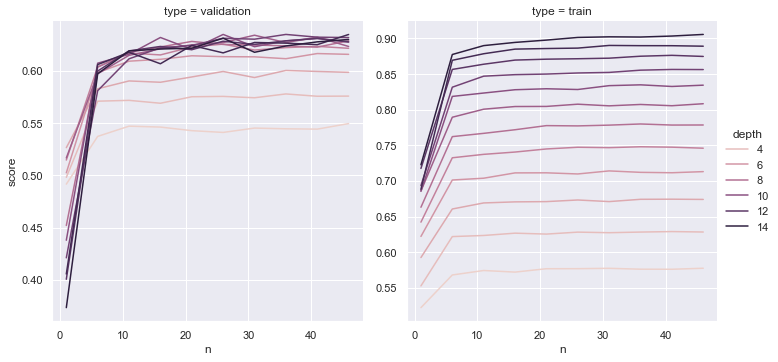

In [92]:
RF0 = RF(df_X0, df_y0,show_graph=True)
RF0

Temps de calcul : 98.69 s


['TotalGHGEmissions',
 'df_X1',
 'Random Forest',
 ('n_estimators', 'max_depth'),
 (41, 10),
 0.436,
 98.69]

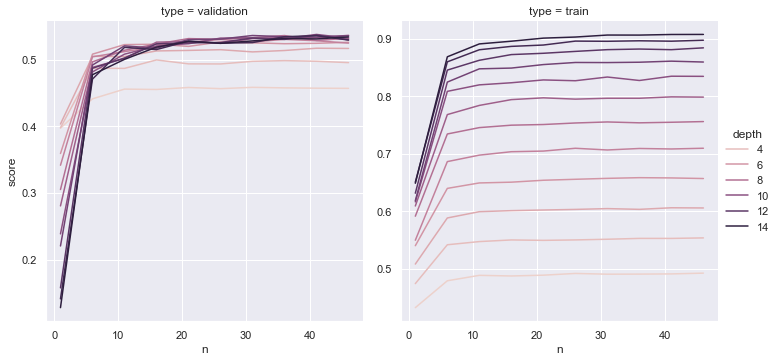

In [93]:
RF1 = RF(df_X1, df_y1,show_graph=True)
RF1

Temps de calcul : 103.60 s


['TotalGHGEmissions',
 'df_X2',
 'Random Forest',
 ('n_estimators', 'max_depth'),
 (41, 11),
 0.425,
 103.6]

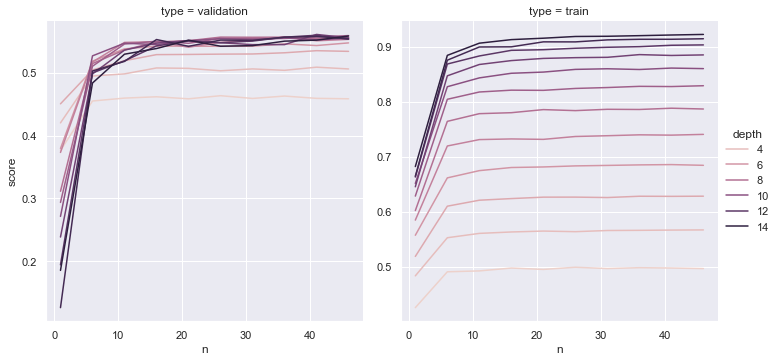

In [94]:
RF2 = RF(df_X2, df_y2, show_graph=True)
RF2

- On voit que le maximum des performances est rapidement atteint en fonction du nombre d'arbres de décisions utilisés. 
- Plus on augmente la profondeur maximale des arbres et plus on colle au training set. Cependant si on regarde les performances sur le validation set on voit que la performance passe par un optimum avant de baisser lorsqu'on augmente d'avantage la profondeur, car le modèle tend à sur-apprendre sur le jeu d'entraînement.
- Enfin on calcule les performances du modèle optimal sur un jeu de données qui n'a pas servi à l'entraînement, le test set, afin de pouvoir comparer les diférents modèles entre eux (c'est ce score qui est renvoyé par la fonction).

In [111]:
def tracer_arbre(X, y):
    # Affiche un des n arbres de décision pour illustration
    rf = RandomForestRegressor(n_estimators=10, max_depth = 5)
    rf.fit(X, y)

    fn = X.columns
    cn = y.name
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,10))
    tree.plot_tree(rf.estimators_[0],
                   feature_names=fn,
                    class_names=cn,
                    filled=True,
                    fontsize=12);

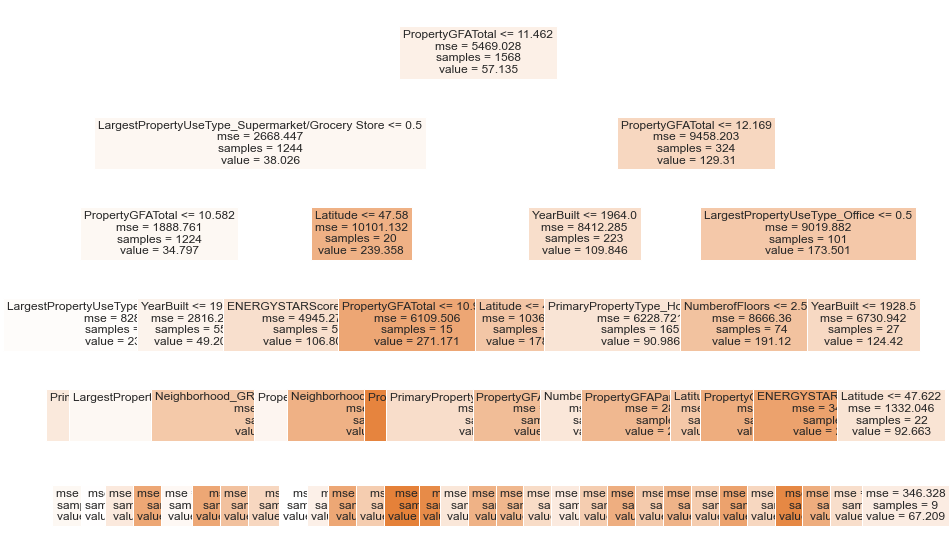

In [112]:
# Illustration d'un arbre de décision
tracer_arbre(df_X2,df_y2)

##  Régression Lasso

La régression Lasso est un modèle linéaire qui peut être utilisé dans le but de réduire le nombre de features, en effet ce type de régulation permet de nullifier complètement un coefficient associé à une variable.

In [113]:
from sklearn.linear_model import LinearRegression, Lasso

In [114]:
def visu_Lasso(df_X, df_y, show_graph=False, tol=0.001, return_index=False):
    """
    Fonction utilisant une régression Lasso, permet de réduire 
    le nombre de variables explicatives d'un jeu de données.
    Trace des graphes interprétatifs si demandé.
    Renvoit l'index des features significatives si demandé en argument 
    (tuple composé de l'index des features significatives et des 
    features inutiles).
    """
    start = time.time()
    name = get_df_name(df_X)
    
    # On sépare le jeu de données en training et test sets
    X_train, X_test, y_train, y_test = train_test_split(df_X.values, df_y.values, test_size=0.3, random_state=0)

    # Obtention de la baseline par régression linéaire simple
    lr = TransformedTargetRegressor(regressor=linear_model.LinearRegression(), 
                                       func=np.log1p, 
                                       inverse_func=np.expm1)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    score = lr.score(X_test, y_test)
    print(f'régression linéaire simple, R² = {score}')
    baseline_error = mean_squared_error(y_test, y_pred)

    
    # Régression Lasso
    n_alphas = 100
    alphas = np.logspace(-6, 1, n_alphas)
    lasso = linear_model.Lasso(max_iter=30000, tol=tol)

    coefs = []
    errors = []
    r2 = []
    feat_vec = []
    
    y_train_log = np.log1p(y_train)
    for a in alphas:
        lasso.set_params(alpha=a)
        lasso.fit(X_train, y_train_log)
        coefs.append(lasso.coef_)
        y_pred_log = lasso.predict(X_test)
        y_pred = np.expm1(y_pred_log)
        errors.append(mean_squared_error(y_test, y_pred))            
        r2.append(r2_score(y_test, y_pred))
        feat_vec.append(np.shape(np.nonzero(lasso.coef_))[1])

    # Indice du alpha optimum
    id_min = errors.index(min(errors))
    alpha_opt = alphas[id_min]
    r2max = r2[id_min]
    print(f'régression Lasso, R² = {r2max}')

    # Features dont les coefficients sont non nuls
    num_feat = np.nonzero(coefs[id_min])[0].tolist()
    index_feat = df_X.iloc[:, num_feat].columns
    # Features inutiles
    index_nul = df_X.columns.difference(index_feat)
    print(f'{len(index_feat)} variables sélectionnées')
    print(f'{df_X.shape[1]-len(index_feat)} variables non significatives ont été supprimées')
    
    # Afficher temps de calcul
    temps = time.time()-start
    print(f'Temps de calcul : {temps:.2f} s')

    # Graphiques
    if show_graph == True:

        ax = plt.gca()
        ax.plot(alphas, coefs)
        ax.set_xscale('log')
        plt.xlabel('alpha')
        plt.ylabel('weights')
        plt.axis('tight')
        plt.title('Lasso coefficients as a function of the regularization')
        plt.show()
        
        ax = plt.gca()
        ax.plot(alphas, errors)
        ax.plot([min(alphas), max(alphas)], [baseline_error, baseline_error])
        ax.set_xscale('log')
        plt.xlabel('alpha')
        plt.ylabel('error')
        ax.legend(['Lasso', 'Linear'])
        plt.axis('tight')
        plt.title('Erreur quadratique moyenne (MSE) en fonction de alpha')
        plt.show()
        
        ax = plt.gca()
        ax.plot(alphas, feat_vec)
        ax.set_xscale('log')
        plt.xlabel('alpha')
        plt.ylabel('error')
        plt.axis('tight')
        plt.title('Nombre de features non nulles en fonction de alpha')
        plt.show()

    if return_index==True:
        return (index_feat, index_nul)
    
    resultat = [df_y.name, name, 'Lasso', 'alpha', "%.2E"%alpha_opt, round(r2[id_min],3), round(temps,2)]
    return resultat

In [116]:
def LassoCV(df_X, df_y, n_pca=100, show_graph=False, tol=0.01, return_index=False):
    """
    Régression Lasso avec validation croisée à 5 folds.
    Renvoit alpha optimal et le score sur le test set.
    """
    start = time.time()
    name = get_df_name(df_X)
    
    # On sépare le jeu de données en training et test sets
    X_train, X_test, y_train, y_test = train_test_split(df_X.values, df_y.values, test_size=0.2, random_state=0)
    
    # Régression Lasso avec cross validation
    n_alphas = 100
    alphas = np.logspace(-6, 1, n_alphas)
    
#     model_pipe = Pipeline([('model', linear_model.Lasso(max_iter=40000, tol=tol))])
    model_pipe = Pipeline([('scaler', StandardScaler()),
                       ('reduce_dims', PCA(n_components=n_pca)),
                       ('model', linear_model.Lasso(max_iter=40000, tol=tol))])
    params = {'model__alpha': alphas}
    
    model = TransformedTargetRegressor(GridSearchCV(model_pipe, 
                                                    param_grid=params, 
                                                    cv=5,
                                                    return_train_score=False), 
                                       func=np.log1p, 
                                       inverse_func=np.expm1)
    model.fit(X_train, y_train)
    
    # Résultats     
    res = model.regressor_.cv_results_
    alpha = res['param_model__alpha']
    validation_score = res['mean_test_score']

    # Alpha optimum
    id_opt = validation_score.argmax()
    alpha_opt = alphas[id_opt]
      
    # Performances sur le test set avec le modèle optimal
    model_pipe = Pipeline([
                        ('scaler', StandardScaler()),
                       ('reduce_dims', PCA(n_components=n_pca)),
                       ('model', linear_model.Lasso(max_iter=40000, 
                                                    tol=tol,
                                                    alpha = alpha_opt))])
    model = TransformedTargetRegressor(regressor=model_pipe,
                                   func=np.log1p, 
                                   inverse_func=np.expm1)
    
    model.fit(X_train, y_train)
    test_score_max = model.score(X_test, y_test)   
    
    temps = time.time()-start
    resultat = [df_y.name, name, 'Lasso', 'alpha', "%.2E"%alpha_opt, round(test_score_max,3), round(temps,2)]
    return resultat

In [117]:
# Enregistrement des résultats avec cross validation
Lasso0 = LassoCV(df_X0, df_y0)
Lasso0

['SiteEnergyUse(kBtu)', 'df_X0', 'Lasso', 'alpha', '5.59E-03', 0.606, 16.78]

In [118]:
Lasso1 = LassoCV(df_X1, df_y1)
Lasso1

['TotalGHGEmissions', 'df_X1', 'Lasso', 'alpha', '2.92E-03', 0.402, 11.87]

In [119]:
Lasso2 = LassoCV(df_X2, df_y1)
Lasso2

['TotalGHGEmissions', 'df_X2', 'Lasso', 'alpha', '2.92E-03', 0.481, 12.02]

régression linéaire simple, R² = 0.5981594132261041
régression Lasso, R² = 0.6293483428713882
23 variables sélectionnées
99 variables non significatives ont été supprimées
Temps de calcul : 38.11 s


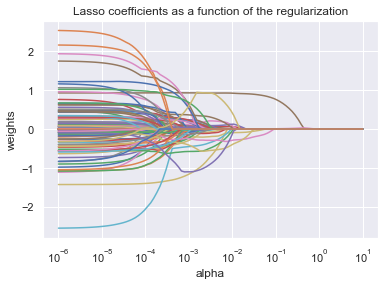

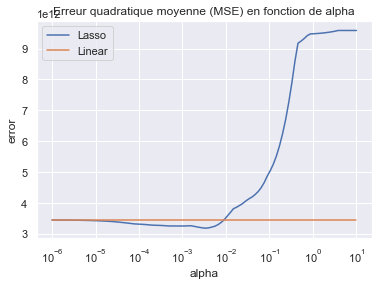

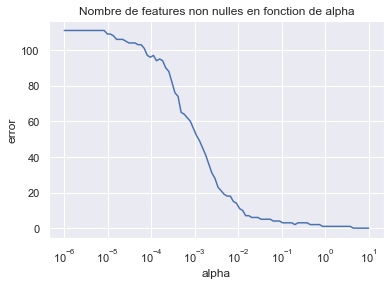

['SiteEnergyUse(kBtu)', 'df_X0', 'Lasso', 'alpha', '3.43E-03', 0.629, 38.11]

In [126]:
# Visualisation des coefficients et de l'erreur, pour illustration du phénomène de régularisation
visu_Lasso(df_X0, df_y0, show_graph=True)

régression linéaire simple, R² = 0.37259878386986567
régression Lasso, R² = 0.38453124572060493
41 variables sélectionnées
81 variables non significatives ont été supprimées
Temps de calcul : 28.23 s


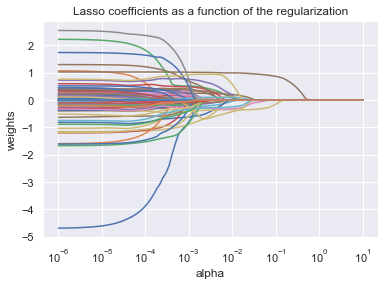

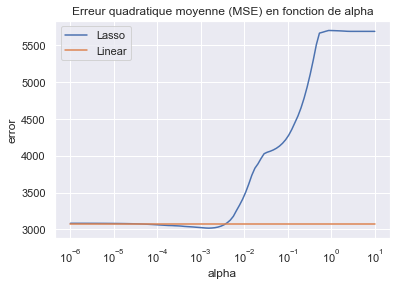

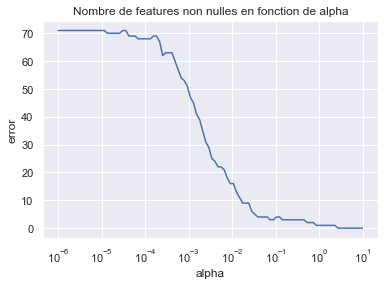

['TotalGHGEmissions', 'df_X1', 'Lasso', 'alpha', '1.52E-03', 0.385, 28.23]

In [127]:
# Visualisation des coefficients et de l'erreur
visu_Lasso(df_X1, df_y1, show_graph=True)

régression linéaire simple, R² = 0.45056525380883206


E:\Users\Windows\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 71.83386210010008, tolerance: 2.6277407320055115
  model = cd_fast.enet_coordinate_descent(
E:\Users\Windows\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 71.83819944822085, tolerance: 2.6277407320055115
  model = cd_fast.enet_coordinate_descent(
E:\Users\Windows\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 71.8432879640726, tolerance: 2.6277407320055115
  model = cd_fast.enet_coordinate_descent(
E:\Users\Windows\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Converg

régression Lasso, R² = 0.4574584645841395
50 variables sélectionnées
73 variables non significatives ont été supprimées
Temps de calcul : 52.24 s


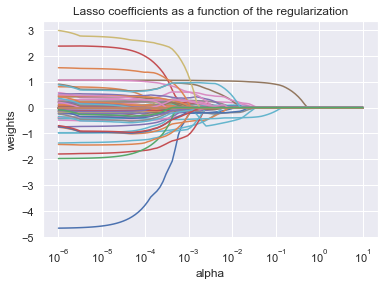

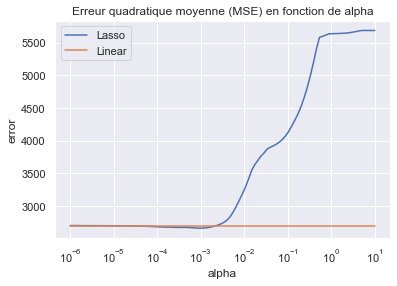

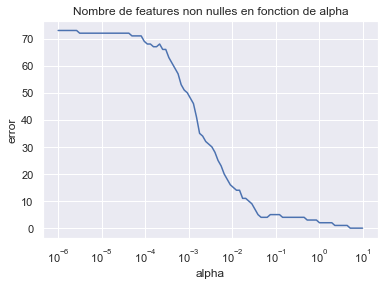

['TotalGHGEmissions', 'df_X2', 'Lasso', 'alpha', '9.33E-04', 0.457, 52.24]

In [128]:
# Visualisation des coefficients et de l'erreur
visu_Lasso(df_X2, df_y1, show_graph=True)

In [129]:
# Features significatives du premier jeu de données
(feat_significatives, feat_null) = visu_Lasso(df_X0, df_y0, return_index=True)

régression linéaire simple, R² = 0.5981594132261041
régression Lasso, R² = 0.6293483428713882
23 variables sélectionnées
99 variables non significatives ont été supprimées
Temps de calcul : 37.95 s


In [130]:
feat_significatives

Index(['YearBuilt', 'PropertyGFATotal', 'PropertyGFAParking',
       'Neighborhood_DOWNTOWN', 'Neighborhood_EAST', 'Neighborhood_NORTH',
       'Neighborhood_SOUTHWEST', 'ComplianceStatus_Compliant',
       'ComplianceStatus_Non-Compliant',
       'PrimaryPropertyType_High-Rise Multifamily',
       'PrimaryPropertyType_Hotel', 'PrimaryPropertyType_Low-Rise Multifamily',
       'PrimaryPropertyType_Other',
       'PrimaryPropertyType_Supermarket / Grocery Store',
       'PrimaryPropertyType_Warehouse', 'PrimaryPropertyType_Worship Facility',
       'BuildingType_Multifamily MR (5-9)', 'BuildingType_Nonresidential COS',
       'LargestPropertyUseType_Distribution Center',
       'LargestPropertyUseType_Multifamily Housing',
       'LargestPropertyUseType_Non-Refrigerated Warehouse',
       'LargestPropertyUseType_Self-Storage Facility',
       'LargestPropertyUseType_Supermarket/Grocery Store'],
      dtype='object')

In [131]:
feat_null

Index(['BuildingType_Campus', 'BuildingType_Multifamily HR (10+)',
       'BuildingType_Multifamily LR (1-4)', 'BuildingType_NonResidential',
       'BuildingType_Nonresidential WA', 'BuildingType_SPS-District K-12',
       'ComplianceStatus_Error - Correct Default Data',
       'LargestPropertyUseType_Adult Education',
       'LargestPropertyUseType_Automobile Dealership',
       'LargestPropertyUseType_Bank Branch',
       'LargestPropertyUseType_College/University',
       'LargestPropertyUseType_Financial Office',
       'LargestPropertyUseType_Fire Station',
       'LargestPropertyUseType_Fitness Center/Health Club/Gym',
       'LargestPropertyUseType_Food Service',
       'LargestPropertyUseType_Hospital (General Medical & Surgical)',
       'LargestPropertyUseType_Hotel', 'LargestPropertyUseType_K-12 School',
       'LargestPropertyUseType_Laboratory', 'LargestPropertyUseType_Library',
       'LargestPropertyUseType_Lifestyle Center',
       'LargestPropertyUseType_Manufacturing

## Réseaux de neurones

Les réseaux de neurones sont des modèles ayant connu un certain essor dans les années 2010, en particulier dans le traitement de l'image et de la vidéo. Ce sont des modèles qui permettent de modéliser des phénomènes complexes. En contrepartie ils sont plus difficiles à paramétrer du fait du nombre élevé d'hyperparamètres à régler correctement.

In [148]:
# pip install tensorflow

In [149]:
# pip install keras

In [90]:
from keras.layers import Dense, Activation
from keras.models import Sequential

La fonction suivante permet de définir le nombre de couches et de neurones par couche comme des attributs d'un modèle de type keras.

In [91]:
def create_model(n_layer, n_unit, n_features):
    # Initialising the ANN
    model = Sequential()

    # Adding the input layer
    model.add(Dense(n_unit, activation = 'relu', input_dim = n_features))

    for n in range(n_layer):
        # Adding a hidden layer
        model.add(Dense(units = n_unit, activation = 'relu'))

    # Adding the output layer
    model.add(Dense(units = 1))

    # Compiling the Neural Network
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')

    return model

Pour pouvoir être reconnu comme un modèle de type sckit learn et être manipulé par les méthodes de cette librairie on utilise le wrapper KerasRegressor.

In [92]:
from keras.wrappers.scikit_learn import KerasRegressor

In [96]:
def ANN(X, y):
    """
    Régression à l'aide d'un réseau de neurones.
    Cross validation 5 folds.
    Les données sont standardisées avec StandardScaler.
    """
    # Splitting the dataset into the Training set and Test set
    start = time.time()
    # n_pca=80
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
    n_features=X.shape[1]

    keras_estimator = KerasRegressor(build_fn=create_model, verbose=0)

    model_pipe = Pipeline([('scaler', StandardScaler()),
#                            ('reduce_dims', PCA(n_components=n_pca)),
                           ('kr', keras_estimator)])

    # Define the grid search parameters
    params = {'kr__n_features': [n_features],
            'kr__epochs': [200, 300],
              'kr__batch_size': [48, 64],
             'kr__n_layer': [10, 12],
             'kr__n_unit': [5, 7]}

    model = TransformedTargetRegressor(GridSearchCV(model_pipe, 
                                                    param_grid=params, 
                                                    cv=5,
                                                    return_train_score=False), 
                                       func=np.log1p, 
                                       inverse_func=np.expm1)
    model.fit(X_train, y_train) 
    temps = time.time()-start
    print(f'temps={temps} s')
    
    # Résultats
#     res = model.regressor_.cv_results_
#     epoch = res['param_kr__epochs']
#     validation_score = res['mean_test_score']

#     # Optimum
#     id_opt = validation_score.argmax()
#     epoch_opt = epoch[id_opt]
#     #     validation_score_max = test_score[id_opt]
#     # temps = time.time()-start

    # Performances sur le test set avec le modèle optimal
    estimator = model.regressor_.best_estimator_
    estimator.fit(X_train, y_train)
#     test_score_max = estimator.score(X_test, y_test)  

    # Hyperparamètres optimaux
    best_params = model.regressor_.best_params_
    y_pred = model.regressor_.best_estimator_.predict(X_test)
    test_score_max = r2_score(y_test,y_pred)
    print(test_score_max)
    
    resultat = [y.name, 
                get_df_name(X), 
                'Neural Network', 
                '(epochs, batch_size, n_layers, n_units)', 
                best_params, 
                round(test_score_max,3), 
                round(temps,2)]
    return resultat

Dans le premier calcul ci dessous, 3 paramètres ont systématiquement été recherchés avec GridSearch, ce qui explique le temps de calcul élevé par rapport aux autres. Pour les deux autres calculs, les paramètres ont été limités à deux, ce qui a permis d'affiner la recherche des hyper-paramètres par itérations successives, avec un temps de calcul raisonnable.

In [118]:
ANN0 = ANN(df_X0, df_y0)
ANN0

temps=7012.483913660049 s
0.6738083389901881


['SiteEnergyUse(kBtu)',
 'df_X0',
 'Neural Network',
 '(epochs, batch_size, n_layers, n_units)',
 {'kr__batch_size': 64,
  'kr__epochs': 300,
  'kr__n_features': 122,
  'kr__n_layer': 10,
  'kr__n_unit': 5},
 0.674,
 7012.48]

In [97]:
ANN1 = ANN(df_X1, df_y1)
ANN1

temps=512.0545825958252 s
0.5122664812293354


['TotalGHGEmissions',
 'df_X1',
 'Neural Network',
 '(epochs, batch_size, n_layers, n_units)',
 {'kr__batch_size': 64,
  'kr__epochs': 200,
  'kr__n_features': 122,
  'kr__n_layer': 10,
  'kr__n_unit': 7},
 0.512,
 512.05]

In [95]:
ANN2 = ANN(df_X2, df_y1)
ANN2

temps=539.7840752601624 s
0.5797638942763923


['TotalGHGEmissions',
 'df_X2',
 'Neural Network',
 '(epochs, batch_size, n_layers, n_units)',
 {'kr__batch_size': 64,
  'kr__epochs': 300,
  'kr__n_features': 123,
  'kr__n_layer': 10,
  'kr__n_unit': 5},
 0.58,
 539.78]

## Comparaison des différents modèles

On compare les différents modèles à l'aide du R² score obtenu sur le test set, qui n'a pas été utilisé pour entraîner le modèle et constitue un jeu de données inconnues.

In [116]:
data = []

In [117]:
data.append(knn0)
data.append(knn1)
data.append(knn2)
data.append(Lasso0)
data.append(Lasso1)
data.append(Lasso2)
data.append(RF0)
data.append(RF1)
data.append(RF2)
data.append(ANN0)
data.append(ANN1)
data.append(ANN2)

In [118]:
df = pd.DataFrame(data, columns=['Target', 'Features', 'Modèle', 'Hyperparamètre', 'Hyp. Opt.', 'R2', 'Temps calcul (s)'])

In [119]:
df

,Target,Features,Modèle,Hyperparamètre,Hyp. Opt.,R2,Temps calcul (s)
0,SiteEnergyUse(kBtu),df_X0,k-NN,n_neighbors,10,0.497,8.30
1,TotalGHGEmissions,df_X1,k-NN,n_neighbors,13,0.333,6.15
2,TotalGHGEmissions,df_X2,k-NN,n_neighbors,10,0.339,6.36
3,SiteEnergyUse(kBtu),df_X0,Lasso,alpha,5.59E-03,0.606,16.78
4,TotalGHGEmissions,df_X1,Lasso,alpha,2.92E-03,0.402,11.87
5,TotalGHGEmissions,df_X2,Lasso,alpha,2.92E-03,0.481,12.02
6,SiteEnergyUse(kBtu),df_X0,Random Forest,"(n_estimators, max_depth)","(36, 11)",0.672,134.37
7,TotalGHGEmissions,df_X1,Random Forest,"(n_estimators, max_depth)","(41, 10)",0.436,98.69
8,TotalGHGEmissions,df_X2,Random Forest,"(n_estimators, max_depth)","(41, 11)",0.425,103.60
9,SiteEnergyUse(kBtu),df_X0,Neural Network,"(epochs, batch_size, n_layers, n_units)","{'kr__batch_size': 64, 'kr__epochs': 300, 'kr_...",0.674,7012.48


Afin de choisir le modèle le plus performant nous mettons en regard la précision de la prédiction d'une part, à travers le R² score, et le temps de calcul nécessaire à l'élaboration du modèle de régression.

On remarque globalement une qualité de prédiction croissante avec la complexité du modèle.

*Note: dans le cas du réseau de neurones, le premier calcul a été lancé avec 3 paramètres de plus dans le GridSearch, ce qui explique son temps de calcul d'environ 2h.*

### Choix final
Selon la variable cible étudiée, on ne choisit pas le même modèle. 

Pour la **consommation électrique**, le Lasso, Random Forest ainsi que le réseau de neurones donnent tous les trois une qualité de prédiction satisfaisante. A partir de là, le choix se fait en fonction du temps utilisé pour paramétrer le modèle. Ici, la complexité du réseau de neurones ne justifie pas un gain si faible par rapport au Random Forest. On choisit donc pour cette cible: **Random Forest**.

Pour les **émission de CO2**, le **réseau de neurones** se démarque clairement des autres modèles par sa qualité de prédiction supérieure et ne laisse pas de place au débat. On remarque également que l'indice **ENERGY Star Score** s'avère utile dans la prédiction des émissions puisqu'elle augmente le score de la régression.